# Playing with the Iris data to learn LDA using http://sebastianraschka.com/Articles/2014_python_lda.html 

### Importing the libraries and data

In [15]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from matplotlib import pyplot as plt
import math

%matplotlib inline

### Check out the data

In [12]:
# Load the Iris data into a dataframe
iris = load_iris()

data = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['class_label'])

In [23]:
# Check out the dataframe
data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class_label
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


In [29]:
feature_dict = {i:label for i,label in zip(
                range(4),
                  ('sepal length in cm',
                  'sepal width in cm',
                  'petal length in cm',
                  'petal width in cm', ))}

label_dict = {0: 'Setosa', 1: 'Versicolor', 2:'Virginica'}

In [30]:
X = data[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']].values
y = data['class_label'].values

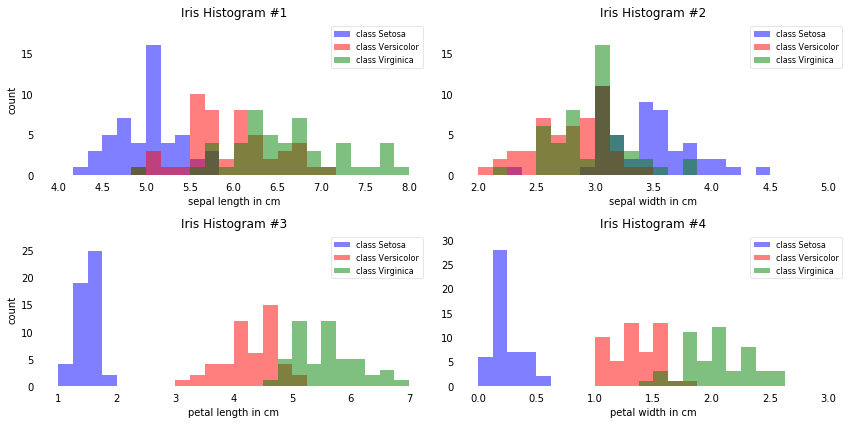

In [31]:
# Visualize the data in histograms

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12,6))

for ax, cnt in zip(axes.ravel(), range(4)):
    
    # set bin sizes
    min_b = math.floor(np.min(X[:,cnt]))
    max_b = math.ceil(np.max(X[:,cnt]))
    bins = np.linspace(min_b, max_b, 25)
    
    # plotting the histograms
    for lab, col in zip(range(0,3), ('blue', 'red', 'green')):
        ax.hist(X[y == lab, cnt],
                    color = col,
                    label = 'class %s' %label_dict[lab],
                    bins = bins,
                    alpha = 0.5)
    ylims = ax.get_ylim()
    
    # plot annotation
    leg = ax.legend(loc = 'upper right', fancybox = True, fontsize = 8)
    leg.get_frame().set_alpha(0.5)
    ax.set_ylim([0, max(ylims) + 2])
    ax.set_xlabel(feature_dict[cnt])
    ax.set_title('Iris Histogram #%s' %str(cnt+1))
    
    # hide axis ticks
    ax.tick_params(axis = 'both', which = 'both', bottom = 'off', 
                  top = 'off', labelbottom = 'on', left = 'off',
                  right = 'off', labelleft = 'on')
    
    # remove axis spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
axes[0][0].set_ylabel('count')
axes[1][0].set_ylabel('count')

fig.tight_layout()

plt.show()

## LDA in Five Steps

1. Computing the d-dimensional mean vectors
2. Computing the Scatter Matrices
3. Solving the generalized eigenvalue problem to obtain the linear discriminants
4. Selecting linear discrimminants for the new feature subspace
5. Choosing k eigenvectors with the largest eigenvalues

### Step 1: Computing the d-dimensional mean vectors

Compute the mean vectors of the three different flower classes

In [33]:
np.set_printoptions(precision = 4)

mean_vectors = []
for cl in range(0,3):
    mean_vectors.append(np.mean(X[y == cl], axis = 0))
    print('Mean Vector class %s: %s\n' %(cl, mean_vectors[cl]))

Mean Vector class 0: [ 5.006  3.418  1.464  0.244]

Mean Vector class 1: [ 5.936  2.77   4.26   1.326]

Mean Vector class 2: [ 6.588  2.974  5.552  2.026]



### Step 2: Computing the Scatter Matrices

Compute the two 4x4-dimensional matrices: the within-class and the between-class scatter matrix.

In [36]:
# Within-Class Scatter Matrix

S_W = np.zeros((4,4))
for cl, mv in zip(range(0,3), mean_vectors):
    class_sc_mat = np.zeros((4,4))                     # scatter matrix for each class
    for row in X[y == cl]:
        row, mv = row.reshape(4,1), mv.reshape(4,1)    # make column vectors
        class_sc_mat += (row - mv).dot((row - mv).T)
    S_W += class_sc_mat                                # sum class scatter matrices

print('Within-Class Scatter matrix:\n', S_W)

Within-Class Scatter matrix:
 [[ 38.9562  13.683   24.614    5.6556]
 [ 13.683   17.035    8.12     4.9132]
 [ 24.614    8.12    27.22     6.2536]
 [  5.6556   4.9132   6.2536   6.1756]]


In [39]:
# Between-Class Scatter Matrix

overall_mean = np.mean(X, axis = 0)

S_B = np.zeros((4,4))
for i, mean_vec in enumerate(mean_vectors):
    n = X[y == i, :].shape[0]
    mean_vec = mean_vec.reshape(4,1)            # make column vector
    overall_mean = overall_mean.reshape(4,1)    # make column vector
    S_B += n * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)
    
print('Between-Class Scatter Matrix:\n', S_B)

Between-Class Scatter Matrix:
 [[  63.2121  -19.534   165.1647   71.3631]
 [ -19.534    10.9776  -56.0552  -22.4924]
 [ 165.1647  -56.0552  436.6437  186.9081]
 [  71.3631  -22.4924  186.9081   80.6041]]


### Step 3: Solving the generalized eigenvalue problem for the matrix S_W(-1)* S_B

Finding linear discriminants

In [41]:
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

for i in range(len(eig_vals)):
    eigvec_sc = eig_vecs[:,i].reshape(4,1)
    print('\nEigenvector {}: \n{}'.format(i+1, eigvec_sc.real))
    print('Eigenvalue {:}: {:.2e}'.format(i+1, eig_vals[i].real))


Eigenvector 1: 
[[-0.2049]
 [-0.3871]
 [ 0.5465]
 [ 0.7138]]
Eigenvalue 1: 3.23e+01

Eigenvector 2: 
[[ 0.009 ]
 [ 0.589 ]
 [-0.2543]
 [ 0.767 ]]
Eigenvalue 2: 2.78e-01

Eigenvector 3: 
[[ 0.0891]
 [-0.3542]
 [-0.4184]
 [ 0.7925]]
Eigenvalue 3: -8.53e-16

Eigenvector 4: 
[[ 0.0891]
 [-0.3542]
 [-0.4184]
 [ 0.7925]]
Eigenvalue 4: -8.53e-16


In [44]:
# Checking the eigenvector-eigenvalue calculation

for i in range(len(eig_vals)):
    eigv = eig_vecs[:,i].reshape(4,1)
    np.testing.assert_array_almost_equal(np.linalg.inv(S_W).dot(S_B).dot(eigv),
                                        eig_vals[i] * eigv,
                                        decimal = 6, err_msg = '', verbose = True)
print('ok')

ok


### Step 4: Sorting the eigenvectors by decreasing eigenvalues

The eigenvectors with the lowest eigenvalues bear the least information about the distribution of the data -- therefore, we want to drop those

In [49]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs = sorted(eig_pairs, key = lambda k: k[0], reverse = True)

# Confirm the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in decreasing order:\n')
for i in eig_pairs:
    print(i[0])

Eigenvalues in decreasing order:

32.2719577997
0.27756686384
2.61409399653e-15
2.61409399653e-15


In [50]:
# Express the 'explained variance' as percentage

print('Variance explained:\n')
eigv_sum = sum(eig_vals)
for i,j in enumerate(eig_pairs):
    print('Eigenvalue {0:}: {1:.2%}'.format(i+1, (j[0]/eigv_sum).real))

Variance explained:

Eigenvalue 1: 99.15%
Eigenvalue 2: 0.85%
Eigenvalue 3: 0.00%
Eigenvalue 4: 0.00%


In [51]:
print(eig_pairs)

[(32.271957799729826, array([-0.2049+0.j, -0.3871+0.j,  0.5465+0.j,  0.7138+0.j])), (0.27756686384004664, array([ 0.0090+0.j,  0.5890+0.j, -0.2543+0.j,  0.7670+0.j])), (2.6140939965341403e-15, array([ 0.0891+0.2143j, -0.3542-0.0946j, -0.4184-0.0932j,  0.7925+0.j    ])), (2.6140939965341403e-15, array([ 0.0891-0.2143j, -0.3542+0.0946j, -0.4184+0.0932j,  0.7925-0.j    ]))]


In [52]:
# Choosing k eigenvectors with the largest eigenvalues
# Constructing a 4x2 eigenvector matrix based on the 2 most informative eigenpairs
# Therefore reducing the original 4-dimensional feature space into a 2-dimensional feature subspace

W = np.hstack((eig_pairs[0][1].reshape(4,1), eig_pairs[1][1].reshape(4,1)))
print('Matrix W:\n', W.real)

Matrix W:
 [[-0.2049  0.009 ]
 [-0.3871  0.589 ]
 [ 0.5465 -0.2543]
 [ 0.7138  0.767 ]]


### Transforming the samples onto the new subspace

Use the 4x2-dimensional matrix W to transform the samples using Y = X x W

In [53]:
X_lda = X.dot(W)
assert X_lda.shape == (150,2), 'The matrix is not 150x2 dimensional.'

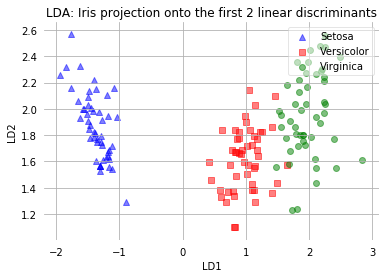

In [54]:
from matplotlib import pyplot as plt

def plot_step_lda():

    ax = plt.subplot(111)
    for label,marker,color in zip(
        range(0,3),('^', 's', 'o'),('blue', 'red', 'green')):

        plt.scatter(x=X_lda[:,0].real[y == label],
                y=X_lda[:,1].real[y == label],
                marker=marker,
                color=color,
                alpha=0.5,
                label=label_dict[label]
                )

    plt.xlabel('LD1')
    plt.ylabel('LD2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title('LDA: Iris projection onto the first 2 linear discriminants')

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

    plt.grid()
    plt.tight_layout
    plt.show()

plot_step_lda()

## LDA with scikit-learn 

In [55]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

sklearn_lda = LDA(n_components = 2)
X_lda_sklearn = sklearn_lda.fit_transform(X, y)

In [58]:
def plot_scikit_lda(X, title):

    ax = plt.subplot(111)
    for label,marker,color in zip(
        range(0,3),('^', 's', 'o'),('blue', 'red', 'green')):

        plt.scatter(x=X[:,0][y == label],
                    y=X[:,1][y == label] * -1, # flip the figure
                    marker=marker,
                    color=color,
                    alpha=0.5,
                    label=label_dict[label])

    plt.xlabel('LD1')
    plt.ylabel('LD2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title(title)

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

    plt.grid()
    plt.tight_layout
    plt.show()

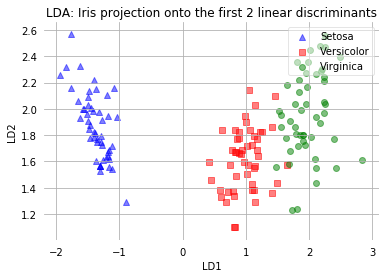

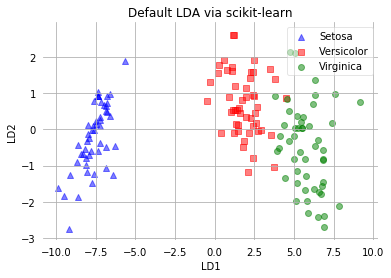

In [59]:
plot_step_lda()
plot_scikit_lda(X_lda_sklearn, title='Default LDA via scikit-learn')